In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

In [29]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [30]:
data_url = (r'C:\Users\soumajit\Desktop\froyo\Online Retail.xlsx')
df = pd.read_excel(data_url)

In [31]:
df.dropna(subset=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'], inplace=True)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [32]:
print(df.describe())

            Quantity                    InvoiceDate      UnitPrice  \
count  397884.000000                         397884  397884.000000   
mean       12.988238  2011-07-10 23:41:23.511023360       3.116488   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 14:39:00       1.950000   
75%        12.000000            2011-10-20 14:33:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       179.331775                            NaN      22.097877   

          CustomerID  
count  397884.000000  
mean    15294.423453  
min     12346.000000  
25%     13969.000000  
50%     15159.000000  
75%     16795.000000  
max     18287.000000  
std      1713.141560  


In [33]:
df['Description'] = df['Description'].str.strip()
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

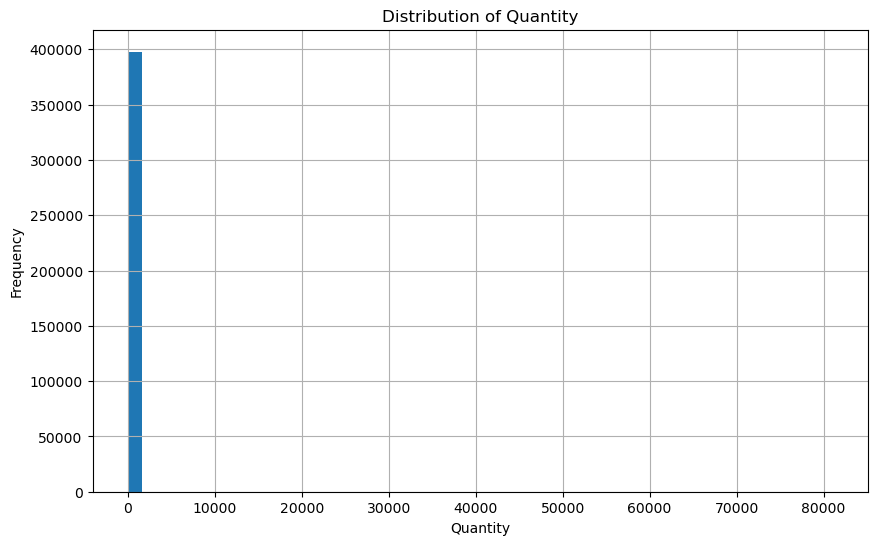

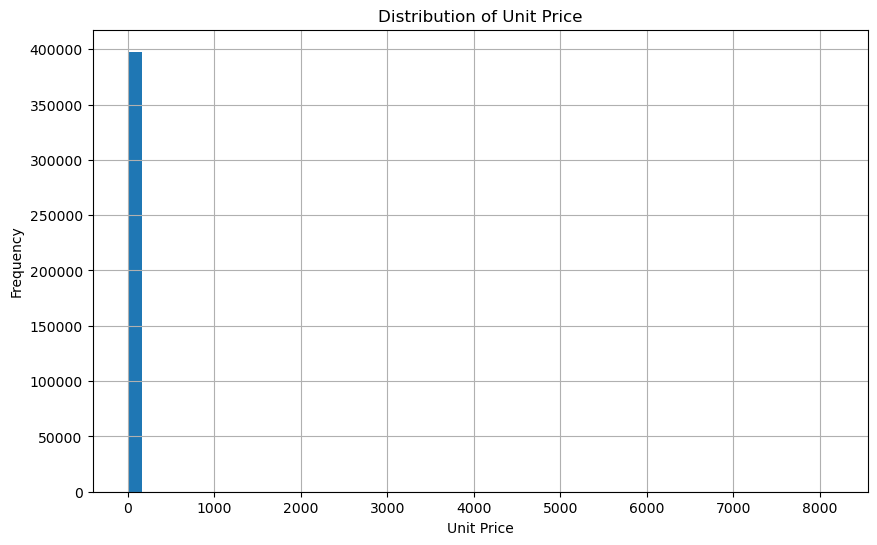

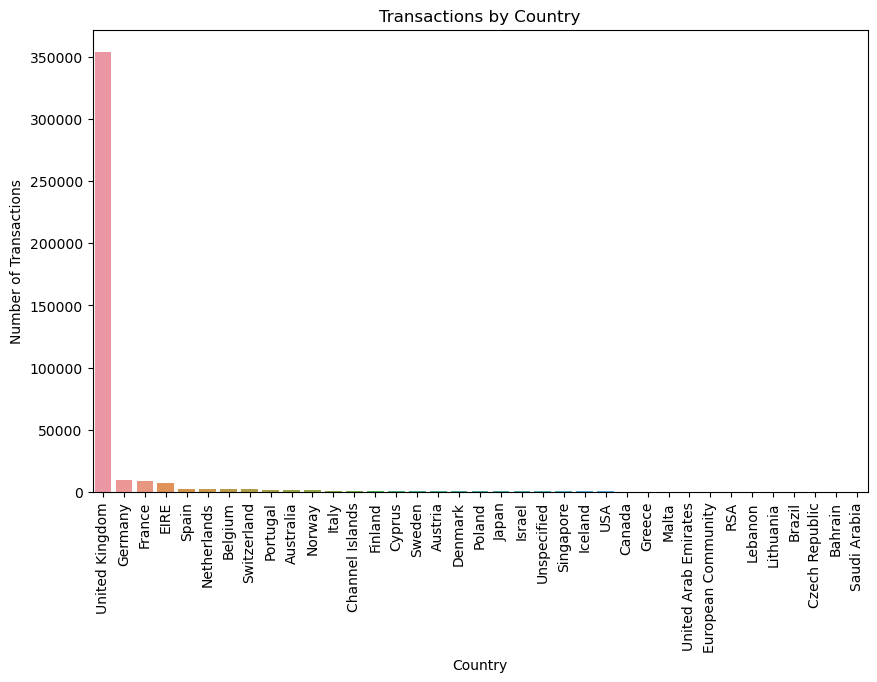

In [34]:
plt.figure(figsize=(10, 6))
df['Quantity'].hist(bins=50)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
df['UnitPrice'].hist(bins=50)
plt.title('Distribution of Unit Price')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Country', order=df['Country'].value_counts().index)
plt.title('Transactions by Country')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)
plt.show()

In [35]:
basket = (df[df['Country'] == "United Kingdom"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [36]:
def encode_units(x):
    return 1 if x >= 1 else 0

basket_sets = basket.map(encode_units)

In [37]:
frequent_itemsets = fpgrowth(basket_sets, min_support=0.02, use_colnames=True)

print("Top 10 Frequent Item Sets:")
print(frequent_itemsets.head(10))

Top 10 Frequent Item Sets:
    support                              itemsets
0  0.113180  (WHITE HANGING HEART T-LIGHT HOLDER)
1  0.026313              (HAND WARMER UNION JACK)
2  0.078097       (ASSORTED COLOUR BIRD ORNAMENT)
3  0.039829            (HOME BUILDING BLOCK WORD)
4  0.032080            (LOVE BUILDING BLOCK WORD)
5  0.029917                 (DOORMAT NEW ENGLAND)
6  0.021987   (FELTCRAFT PRINCESS CHARLOTTE DOLL)
7  0.045116            (JAM MAKING SET WITH JARS)
8  0.056770      (PAPER CHAIN KIT 50'S CHRISTMAS)
9  0.051304   (WOODEN PICTURE FRAME WHITE FINISH)


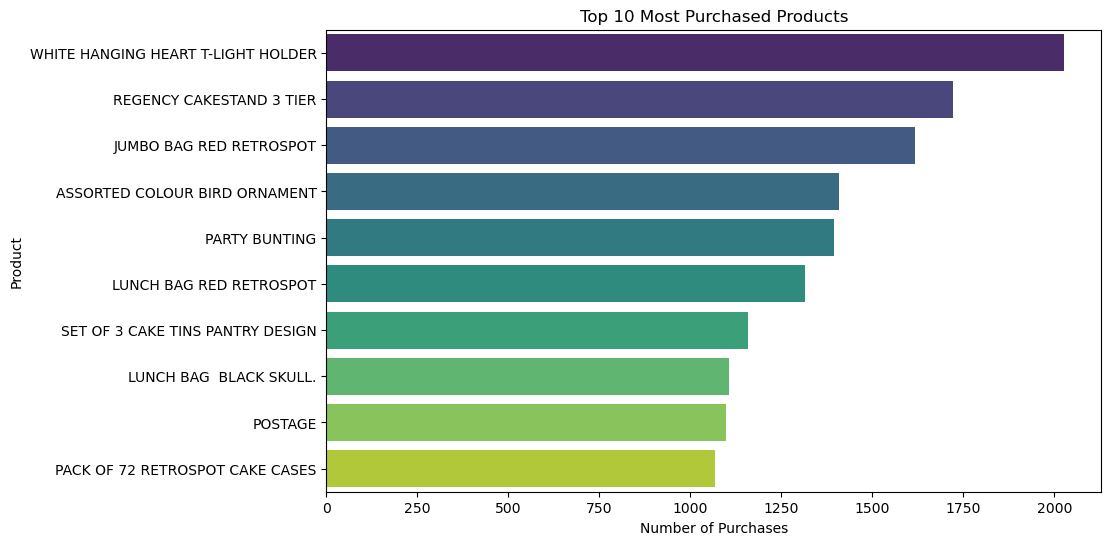

In [38]:
top_products = df['Description'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Most Purchased Products')
plt.xlabel('Number of Purchases')
plt.ylabel('Product')
plt.show()

In [39]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])

print("Association Rules:")
print(rules.head())

Association Rules:
                                          antecedents  \
55  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...   
56  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   
51                   (PINK REGENCY TEACUP AND SAUCER)   
49                  (GREEN REGENCY TEACUP AND SAUCER)   
53                   (PINK REGENCY TEACUP AND SAUCER)   

                          consequents  antecedent support  consequent support  \
55  (GREEN REGENCY TEACUP AND SAUCER)            0.023009            0.036766   
56  (ROSES REGENCY TEACUP AND SAUCER)            0.024270            0.040731   
51  (GREEN REGENCY TEACUP AND SAUCER)            0.029617            0.036766   
49  (ROSES REGENCY TEACUP AND SAUCER)            0.036766            0.040731   
53  (ROSES REGENCY TEACUP AND SAUCER)            0.029617            0.040731   

     support  confidence       lift  leverage  conviction  zhangs_metric  
55  0.020485    0.890339  24.216650  0.019639    8.783780       0.981284  
5

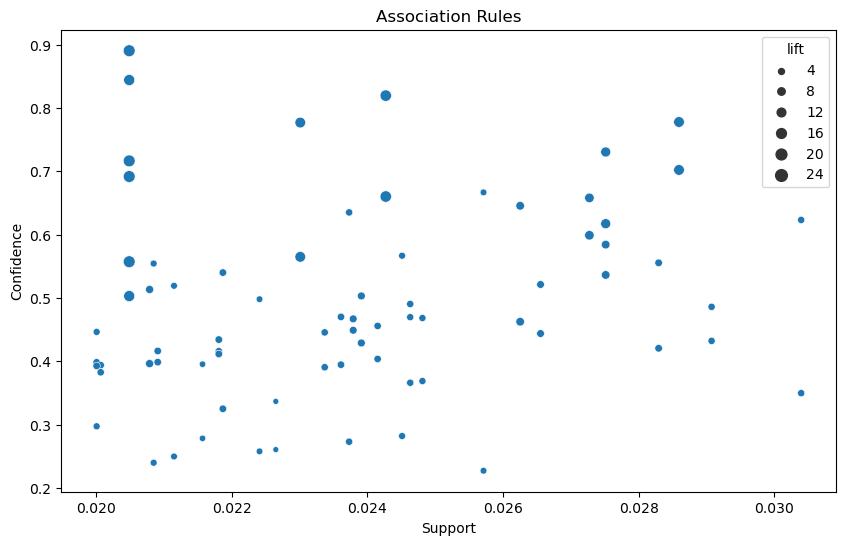

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="support", y="confidence", size="lift", data=rules)
plt.title('Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

In [41]:
recommendations = []

for index, rule in rules.iterrows():
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    recommendations.append(f"Consider placing '{consequents}' near '{antecedents}' to encourage cross-selling.")

In [42]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
now = pd.Timestamp('now')

rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,
    'InvoiceNo': 'count',
    'Quantity': 'sum',
    'UnitPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Quantity': 'Monetary'})

In [43]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

In [44]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)
rfm_df['Cluster'] = kmeans.labels_

print(rfm_df.head())

            Recency  Frequency  Monetary  UnitPrice  Cluster
CustomerID                                                  
12346.0        4913          1     74215       1.04        3
12347.0        4590        182      2458     481.21        0
12348.0        4663         31      2341     178.71        0
12349.0        4606         73       631     605.10        0
12350.0        4898         17       197      65.30        1


In [45]:
print("\n### Recommendations ###")
for rec in recommendations[:10]:
    print(rec)

print("\n### Customer Segments ###")
print(rfm_df.groupby('Cluster').mean())



### Recommendations ###
Consider placing 'GREEN REGENCY TEACUP AND SAUCER' near 'ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY TEACUP AND SAUCER' to encourage cross-selling.
Consider placing 'ROSES REGENCY TEACUP AND SAUCER' near 'GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY TEACUP AND SAUCER' to encourage cross-selling.
Consider placing 'GREEN REGENCY TEACUP AND SAUCER' near 'PINK REGENCY TEACUP AND SAUCER' to encourage cross-selling.
Consider placing 'ROSES REGENCY TEACUP AND SAUCER' near 'GREEN REGENCY TEACUP AND SAUCER' to encourage cross-selling.
Consider placing 'ROSES REGENCY TEACUP AND SAUCER' near 'PINK REGENCY TEACUP AND SAUCER' to encourage cross-selling.
Consider placing 'GARDENERS KNEELING PAD KEEP CALM' near 'GARDENERS KNEELING PAD CUP OF TEA' to encourage cross-selling.
Consider placing 'PINK REGENCY TEACUP AND SAUCER' near 'ROSES REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER' to encourage cross-selling.
Consider placing 'GREEN REGENCY TEACUP AND SAUCER' n

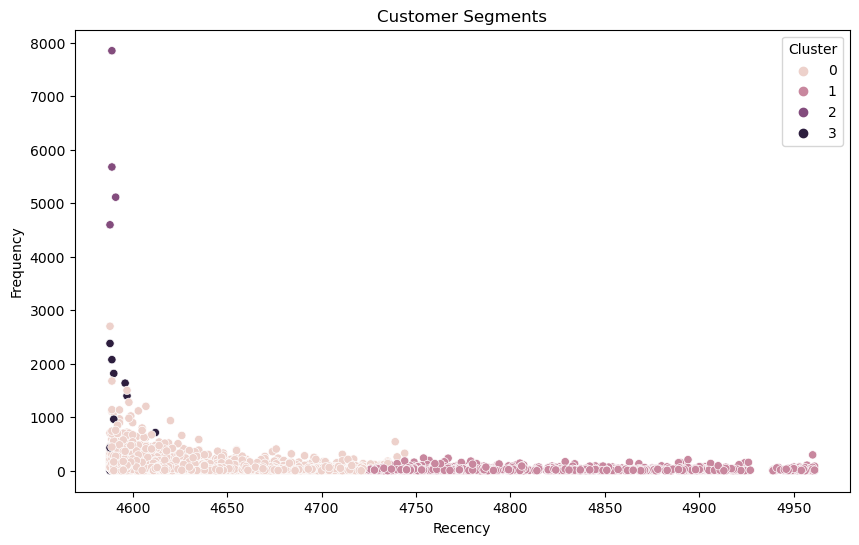

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm_df)
plt.title('Customer Segments')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()